# Getting the trainig data

In [1]:
import pandas as pd

In [2]:
sma_window_short = 20
sma_window_long = 80
num_batches = 1

In [3]:
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

In [4]:
start = dt.datetime(2014, 9, 1)
end = dt.datetime.now()
df = web.DataReader('AAPL', 'iex', start, end)

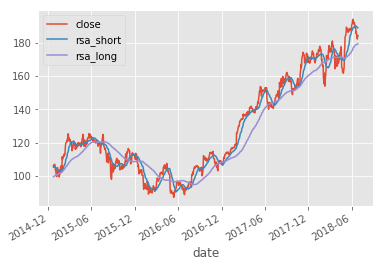

In [5]:
df = df[["close"]]
df["rsa_short"] = pd.Series.rolling(df["close"], window=sma_window_short).mean()
df["rsa_long"] = pd.Series.rolling(df["close"], window=sma_window_long).mean()
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df.plot()

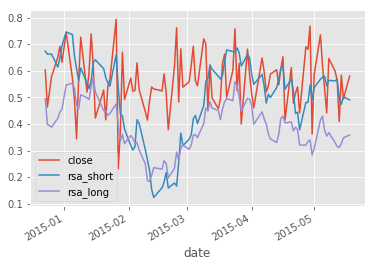

In [6]:
df = df - df.shift(-1)
df.dropna(inplace=True)
A=(df-df.min())/(df.max()-df.min())
A[:100].plot()

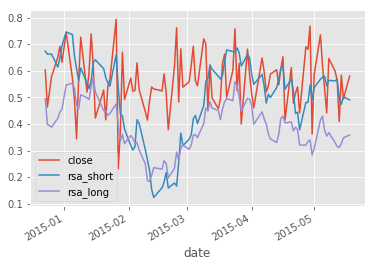

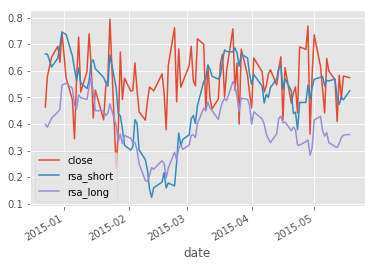

In [7]:
B=A.shift(-1)
A, B = A.dropna(), B.dropna()
A.drop(A.index[-1],inplace=True)
A[:100].plot()
plt.show()
B[:100].plot()
plt.show()

In [8]:
import numpy as np
A = A.values.reshape((A.shape[0], A.shape[1]))
B = B.values.reshape((B.shape[0], B.shape[1]))
A = np.array_split(A, num_batches)
B = np.array_split(B, num_batches)

# Model

In [9]:
import tensorflow as tf

In [10]:
lstm_size = 256
num_features = 3
learning_rate=0.05
layers = 5
iterations = 75
batch_size = 1

In [11]:
def rnn(size): 
    return tf.nn.rnn_cell.BasicRNNCell(size)
def multi(size, lay):
    return tf.nn.rnn_cell.MultiRNNCell([rnn(size) for _ in range(layers)])
with tf.name_scope("cell"):
    cell = multi(lstm_size, layers)
with tf.name_scope("output"):
    output = rnn(num_features)
X = tf.placeholder(tf.float32, [batch_size, None, num_features])
Y = tf.placeholder(tf.float32, [batch_size, None, num_features])
def run ():
    outputs1, state2 = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    outputs2, state2 = tf.nn.dynamic_rnn(output, outputs1, dtype=tf.float32)
    return outputs2
def compute_loss ():
    return tf.losses.mean_squared_error(Y, run())

# Training

Finished backward pass №0, loss: 0.2514186203479767, accuracy: 0.0
Finished backward pass №1, loss: 0.6197772026062012, accuracy: 0.0
Finished backward pass №2, loss: 0.16678482294082642, accuracy: 0.0
Finished backward pass №3, loss: 0.16616016626358032, accuracy: 0.0
Finished backward pass №4, loss: 0.1705116331577301, accuracy: 0.0
Finished backward pass №5, loss: 0.5704208016395569, accuracy: 0.0
Finished backward pass №6, loss: 0.5972186923027039, accuracy: 0.0
Finished backward pass №7, loss: 0.2427586317062378, accuracy: 0.0
Finished backward pass №8, loss: 0.24270465970039368, accuracy: 0.0
Finished backward pass №9, loss: 0.2426367551088333, accuracy: 0.0
Finished backward pass №10, loss: 0.24254916608333588, accuracy: 0.0
Finished backward pass №11, loss: 0.24243198335170746, accuracy: 0.0
Finished backward pass №12, loss: 0.24226835370063782, accuracy: 0.0
Finished backward pass №13, loss: 0.24202539026737213, accuracy: 0.0
Finished backward pass №14, loss: 0.241631656885147

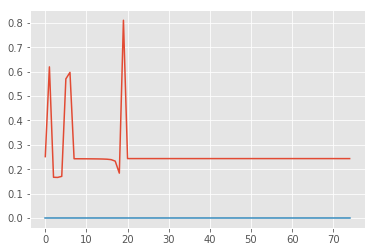

In [12]:
acc = tf.metrics.precision(Y, run())[0]
with tf.Session() as sess:
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(compute_loss())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    losses = []
    accuracies = []
    for i in range(iterations):
        np.random.shuffle(A)
        np.random.shuffle(B)
        a = A[:(batch_size or 1)]
        b = B[:(batch_size or 1)]
        sess.run(optimizer, feed_dict={X:a,Y:b})
        loss = sess.run(compute_loss(), feed_dict={X:a, Y:b})
        ac = sess.run(acc, feed_dict={X:a, Y: b})
        print("Finished backward pass №{}, loss: {}, accuracy: {}".format(i, loss, ac))
        losses.append(loss)
        accuracies.append(ac)
    plt.plot(losses)
    plt.plot(accuracies)
    # Ignore the accuracy

# Add a Keras model (I certainly did something wrong)...

In [13]:
from tensorflow.contrib import keras
Sequential = keras.models.Sequential
baseLSTM = keras.layers.LSTM
class LSTM(baseLSTM):
    def call(self, x, mask=None):
        if self.stateful: 
             self.reset_states()
        return super(LSTM, self).call(x, mask)

In [14]:
model = Sequential()
model.add(LSTM(lstm_size, return_sequences=True, go_backwards=True, batch_input_shape=(batch_size, None, num_features), stateful=True))
model.add(LSTM(num_features, return_sequences=True, go_backwards=True, stateful=True))

In [15]:
model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["acc"])

In [16]:
A = np.asarray(A)
B = np.asarray(B)

In [17]:
history = model.fit(A, B, epochs=iterations)

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 1 samples

In [18]:
#plt.plot(history.history["loss"])

# Alright, I'll change it...

In [19]:
model = Sequential()
model.add(LSTM(lstm_size, return_sequences=True, go_backwards=True, input_shape=(None, num_features), stateful=False))
model.add(LSTM(num_features, return_sequences=True, go_backwards=True, stateful=False))

In [20]:
model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["acc"])

In [21]:
history = model.fit(A, B, epochs=iterations * 4)

Epoch 1/300
1/1 [==============================] - 20s 20s/step - loss: 0.3283 - acc: 0.2846
Epoch 2/300
1/1 [==============================] - 13s 13s/step - loss: 0.0886 - acc: 0.4093
Epoch 3/300
1/1 [==============================] - 14s 14s/step - loss: 0.0318 - acc: 0.2857
Epoch 4/300
1/1 [==============================] - 14s 14s/step - loss: 0.0283 - acc: 0.4002
Epoch 5/300
1/1 [==============================] - 14s 14s/step - loss: 0.0324 - acc: 0.2868
Epoch 6/300
1/1 [==============================] - 14s 14s/step - loss: 0.0251 - acc: 0.4116
Epoch 7/300
1/1 [==============================] - 14s 14s/step - loss: 0.0224 - acc: 0.5136
Epoch 8/300
1/1 [==============================] - 14s 14s/step - loss: 0.0193 - acc: 0.4875
Epoch 9/300
1/1 [==============================] - 14s 14s/step - loss: 0.0179 - acc: 0.6610
Epoch 10/300
1/1 [==============================] - 14s 14s/step - loss: 0.0940 - acc: 0.4717
Epoch 11/300
1/1 [==============================] - 14s 14s/step - lo

Epoch 89/300
1/1 [==============================] - 19s 19s/step - loss: 0.0074 - acc: 0.7925
Epoch 90/300
1/1 [==============================] - 19s 19s/step - loss: 0.0076 - acc: 0.7914
Epoch 91/300
1/1 [==============================] - 21s 21s/step - loss: 0.0103 - acc: 0.6349
Epoch 92/300
1/1 [==============================] - 25s 25s/step - loss: 0.0118 - acc: 0.7132
Epoch 93/300
1/1 [==============================] - 22s 22s/step - loss: 0.0109 - acc: 0.6667
Epoch 94/300
1/1 [==============================] - 22s 22s/step - loss: 0.0074 - acc: 0.7902
Epoch 95/300
1/1 [==============================] - 23s 23s/step - loss: 0.0067 - acc: 0.8061
Epoch 96/300
1/1 [==============================] - 22s 22s/step - loss: 0.0063 - acc: 0.7959
Epoch 97/300
1/1 [==============================] - 21s 21s/step - loss: 0.0063 - acc: 0.7891
Epoch 98/300
1/1 [==============================] - 22s 22s/step - loss: 0.0069 - acc: 0.8039
Epoch 99/300
1/1 [==============================] - 20s 20s/

Epoch 176/300
1/1 [==============================] - 15s 15s/step - loss: 0.0057 - acc: 0.8367
Epoch 177/300
1/1 [==============================] - 15s 15s/step - loss: 0.0066 - acc: 0.7812
Epoch 178/300
1/1 [==============================] - 15s 15s/step - loss: 0.0080 - acc: 0.7732
Epoch 179/300
1/1 [==============================] - 15s 15s/step - loss: 0.0065 - acc: 0.7755
Epoch 180/300
1/1 [==============================] - 15s 15s/step - loss: 0.0053 - acc: 0.8129
Epoch 181/300
1/1 [==============================] - 19s 19s/step - loss: 0.0051 - acc: 0.8039
Epoch 182/300
1/1 [==============================] - 24s 24s/step - loss: 0.0054 - acc: 0.7937
Epoch 183/300
1/1 [==============================] - 18s 18s/step - loss: 0.0062 - acc: 0.7370
Epoch 184/300
1/1 [==============================] - 19s 19s/step - loss: 0.0065 - acc: 0.7415
Epoch 185/300
1/1 [==============================] - 20s 20s/step - loss: 0.0061 - acc: 0.7766
Epoch 186/300
1/1 [==============================]

Epoch 263/300
1/1 [==============================] - 21s 21s/step - loss: 0.0056 - acc: 0.7971
Epoch 264/300
1/1 [==============================] - 21s 21s/step - loss: 0.0058 - acc: 0.8050
Epoch 265/300
1/1 [==============================] - 19s 19s/step - loss: 0.0062 - acc: 0.8005
Epoch 266/300
1/1 [==============================] - 18s 18s/step - loss: 0.0058 - acc: 0.7868
Epoch 267/300
1/1 [==============================] - 16s 16s/step - loss: 0.0054 - acc: 0.8186
Epoch 268/300
1/1 [==============================] - 16s 16s/step - loss: 0.0056 - acc: 0.7834
Epoch 269/300
1/1 [==============================] - 15s 15s/step - loss: 0.0051 - acc: 0.8265
Epoch 270/300
1/1 [==============================] - 15s 15s/step - loss: 0.0046 - acc: 0.8333
Epoch 271/300
1/1 [==============================] - 15s 15s/step - loss: 0.0047 - acc: 0.8084
Epoch 272/300
1/1 [==============================] - 16s 16s/step - loss: 0.0047 - acc: 0.8107
Epoch 273/300
1/1 [==============================]

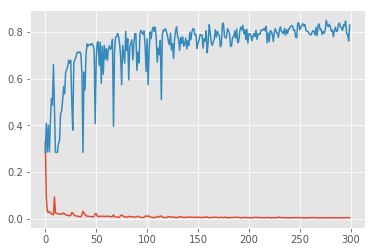

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["acc"])

# Obviously,
the Keras model is better. I will use it for prediction.

In [23]:
def get_data(stock):
    start = dt.datetime(2014, 9, 1)
    end = dt.datetime.now()
    df = web.DataReader(stock, 'iex', start, end)
    df = df[["close"]]
    df["rsa_short"] = pd.Series.rolling(df["close"], window=sma_window_short).mean()
    df["rsa_long"] = pd.Series.rolling(df["close"], window=sma_window_long).mean()
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df - df.shift(-1)
    df.dropna(inplace=True)
    A=(df-df.min())/(df.max()-df.min())
    B=A.shift(-1)
    A, B = A.dropna(), B.dropna()
    A.drop(A.index[-1],inplace=True)
    A = A.values.reshape((A.shape[0], A.shape[1]))
    B = B.values.reshape((B.shape[0], B.shape[1]))
    A = np.array_split(A, num_batches)
    B = np.array_split(B, num_batches)
    A = np.asarray(A)
    B = np.asarray(B)
    return A, B

In [24]:
tX, tY = get_data("TSLA")
score = model.evaluate(tX, tY)

1/1 [==============================] - 3s 3s/step


In [25]:
score[1]

0.875283420085907

# Pretty high accuracy...
Let's add some Monte Carlo!

In [26]:
def evaluate(X, d, n=100, noise=0.1):
    '''Evaluates the training data with NOISE amount of noise and N Monte Carlo instances and returns the mean price direction after D days..'''
    Xs = np.asarray([X for i in range(n)])
    Xs = np.add(Xs, np.random.normal(size=Xs.shape, scale=noise))
    for i in range(d):
        Xs = model.predict(Xs)
    return np.mean(Xs[-1][0])

In [29]:
evaluate(tX[0], 2, 20)

0.13273035

# Time to make some MAAANNNAAAAYYY!!!